In [1]:
import os
import cv2
import time
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision.transforms as TT
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from livelossplot import PlotLosses
from tqdm import tqdm, trange
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [2]:
from cnn.Model import EESPNet_Seg

In [3]:
class MyDataset(Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, imList, labels, transform=None, img_transform = None):
        '''
        :param imList: image list (Note that these lists have been processed and pickled using the loadData.py)
        :param labelList: label list (Note that these lists have been processed and pickled using the loadData.py)
        '''          
        self.imList = imList
        self.labels = labels
        self.transform = transform
        self.img_transform = img_transform
        
    def __transform__(self, x):
        x = x.copy()
        x = np.moveaxis(x, 2, 0)
        x = x.astype('float')
        x -= 128
        x /= 35
        return(x)

    def __back_transform__(self, x):
        x = x.copy()
        x *= 35
        x += 128
        x[x<0] = 0
        x[x>255] = 255
        x = x.astype('uint8')
        x = np.moveaxis(x, 0, 2)
        return(x)

    def _random_rot(self, img, label):
        img = torch.unsqueeze(img, 0).to(device, dtype=torch.float)
        img += (128/35)
        
        label = torch.stack([255 * (label == i) for i in range(3)], 0)
        label = torch.unsqueeze(label, 0).to(device, dtype=torch.float)
        
        theta = torch.empty((img.shape[0], 2,3))
        r = torch.tensor([np.pi * (np.random.random() - 0.5)])
        s = 1 + 0.1*torch.tensor([(np.random.random())])
        d = torch.tensor([0.01 * (0.5 + np.random.random())])
        theta[:,0,0] = torch.cos(r) * s
        theta[:,0,1] = torch.sin(r) * s
        theta[:,0,2] = torch.cos(r) * d
        theta[:,1,0] = -torch.sin(r) * s
        theta[:,1,1] = torch.cos(r) * s
        theta[:,0,2] = torch.sin(r) * d
        theta = theta.to(device)
        
        grid = F.affine_grid(theta, img.size())
        img = F.grid_sample(img, grid)
        img = torch.squeeze(img, 0)
        img -= (128/35)
        
        gridl = F.affine_grid(theta, label.size())
        label = F.grid_sample(label, gridl)
        label = torch.squeeze(label, 0).argmax(0)
        
        return(img, label)

    def __len__(self):
        return len(self.imList)

    def __getitem__(self, idx):
        '''

        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image_name = self.imList[idx]
        image = cv2.imread(image_name, cv2.IMREAD_COLOR)
        label = cv2.imread(self.labels[idx], cv2.IMREAD_GRAYSCALE)
        if self.transform:
            image, label = self.transform(image, label)
            
        if self.img_transform:
            image = self.img_transform(image)
            image = (image - 0.5) * (255/35)
        else:
            image = self.__transform__(image)
            image = torch.from_numpy(image)
            
        label = torch.from_numpy(label)
        
        image, label = self._random_rot(image, label)
        
        image = Variable(image).to(device, dtype=torch.float)
        label = Variable(label).to(device, dtype=torch.long)
    
        return (image, label)

In [4]:
class Scale(object):
    def __init__(self, wi, he):
        self.w = wi
        self.h = he

    def __call__(self, img, label):
        # nearest neighbour interpolation
        img = cv2.resize(img, (self.w, self.h), interpolation=cv2.INTER_NEAREST)
        label = cv2.resize(label, (self.w, self.h), interpolation=cv2.INTER_NEAREST)

        return [img, label]

class Crop(object):
    def __init__(self, w, h):
        self.x = w
        self.y = h

    def __call__(self, img, label):
        h, w = img.shape[:2]
        x1 = np.random.randint(0, w - self.x)
        y1 = np.random.randint(0, h - self.y)
        img_crop = img[y1:y1+self.y, x1:x1+self.x]
        label_crop = label[y1:y1+self.y, x1:x1+self.x]

        return img_crop, label_crop

class RandomCropResize(object):
    def __init__(self, crop_area):
        self.cw = crop_area
        self.ch = crop_area

    def __call__(self, img, label):
        if np.random.random() < 0.5:
            h, w = img.shape[:2]
            x1 = np.random.randint(0, np.min([self.cw, int(w/2)]))
            y1 = np.random.randint(0, np.min([self.ch, int(h/2)]))
            
            img_crop = img[y1:h-y1, x1:w-x1]
            label_crop = label[y1:h-y1, x1:w-x1]

            img_crop = cv2.resize(img_crop, (w, h), interpolation=cv2.INTER_NEAREST)
            label_crop = cv2.resize(label_crop, (w,h), interpolation=cv2.INTER_NEAREST)
            return img_crop, label_crop
        else:
            return [img, label]

class RandomFlip(object):
    def __call__(self, image, label):
        if np.random.random() < 0.5:
                image = cv2.flip(image, 0) # horizontal flip
                label = cv2.flip(label, 0) # horizontal flip
        if np.random.random() < 0.5:
                image = cv2.flip(image, 1) # veritcal flip
                label = cv2.flip(label, 1)  # veritcal flip
        return [image, label]


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, *args):
        for t in self.transforms:
            args = t(*args)
        return args


In [5]:
#Define o mapa de cores para geração da máscara
def colorir(cat):
    h, w = cat.shape[:2]
    msk = np.zeros((h,w,3), dtype = 'uint8')
    msk[cat == 1] = [0,255,0]
    return(msk)

In [6]:
data_transform = Compose([
    RandomCropResize(100),
    RandomFlip(),
    Scale(512, 512)
    ])

img_transform = TT.Compose([
    TT.ToPILImage(),
    TT.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.01, hue=0.01),
    TT.ToTensor()
])

In [16]:
# Diretório das imagens
im_dir = '../../Datasets/SoybeanTS/augmented_lucas/'
lbl_dir = '../../Datasets/SoybeanTS/augmented_lucas/'
img_ext = 'img.jpg'
msk_ext = 'msk.png'

imfx = sorted(os.listdir(im_dir))
imfx = [i for i in imfx if i.endswith(img_ext)]
imfx = [os.path.join(im_dir,  imfx[i]) for i in range(len(imfx))]
imfx = np.array(imfx)

imfy = sorted(os.listdir(lbl_dir))
imfy = [i for i in imfy if i.endswith(msk_ext)]
imfy = [os.path.join(lbl_dir,  imfy[i]) for i in range(len(imfy))]
imfy = np.array(imfy)

im_train = np.arange(len(imfx))
im_val = np.random.choice(im_train, 10, replace=False)
im_train = np.setdiff1d(im_train, im_val)

In [17]:
train_dataset =  MyDataset(imfx[im_train], imfy[im_train], data_transform, img_transform)
val_dataset =  MyDataset(imfx[im_val],  imfy[im_val], data_transform, img_transform)
test_dataset =  MyDataset(imfx,  imfy, data_transform)

print(len(train_dataset),len(val_dataset))

90 10


In [18]:
# Carrega o dataset de treinamento
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=2,
                          shuffle=True,
                          num_workers=0
                         )

# Carrega o dataset de validação
val_loader = torch.utils.data.DataLoader(val_dataset,
                          batch_size=1,
                          shuffle=False,
                          num_workers=0
                         )
test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=1,
                          shuffle=False,
                          num_workers=0
                         )

In [19]:
n_classes = 2
liveloss = PlotLosses()

# Atribui o modelo
model = EESPNet_Seg(n_classes, s=2, channels = 3)
model = model.to(device)
# model.load_state_dict(torch.load('../data/model_drone_GP_best.pth'))
print('Modelo OK')
summary(model, ((3,128,128)))

Modelo OK
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             432
       BatchNorm2d-2           [-1, 16, 64, 64]              32
             PReLU-3           [-1, 16, 64, 64]              16
               CBR-4           [-1, 16, 64, 64]               0
         AvgPool2d-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 24, 64, 64]             192
       BatchNorm2d-7           [-1, 24, 64, 64]              48
             PReLU-8           [-1, 24, 64, 64]              24
               CBR-9           [-1, 24, 64, 64]               0
           Conv2d-10           [-1, 24, 32, 32]             216
         CDilated-11           [-1, 24, 32, 32]               0
           Conv2d-12           [-1, 24, 32, 32]             216
         CDilated-13           [-1, 24, 32, 32]               0
      BatchNorm2d-14         

In [20]:
weight = np.array([1,5])
weight = torch.from_numpy(weight).to(device, dtype=torch.float)
criterion = torch.nn.CrossEntropyLoss(weight)

In [21]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

In [22]:
def calc_msk(outputs):
    preds = []
    for pred in outputs:
        cat = pred.argmax(0)
        pred_tensor = pred[[1]]
        predm = F.max_pool2d(pred_tensor, stride=1, kernel_size=45, padding=22)
        predm = ((predm == pred_tensor).to(device, dtype=torch.long) * cat)
        prednp = predm.cpu().data.numpy()[0]
        coords = np.stack(np.where(prednp))[[1, 0]].transpose()
        msk = np.zeros_like(prednp, dtype = 'uint8')
        for cx, cy in coords:
            cv2.circle(msk, (cx,cy), 10, 1, -1)
        mskt = torch.from_numpy(msk).to(device, dtype = torch.float)
        mskt = torch.stack([1-mskt, mskt])
        preds.append(mskt)
    preds = torch.stack(preds, 0)
    return(preds)

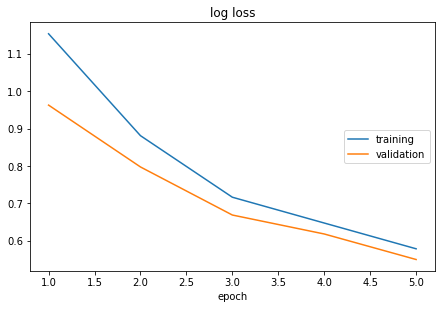


  0%|          | 0/45 [00:00<?, ?it/s]

log loss:
training   (min:    0.579, max:    1.153, cur:    0.579)
validation (min:    0.550, max:    0.963, cur:    0.550)
[0:4] loss: 0.579 time:40.73



 87%|████████▋ | 39/45 [00:27<00:04,  1.33it/s]

In [ ]:
min_loss = 1e9
bad_epochs = 0
liveloss = PlotLosses()

for epoch in range(100):
    bad_epochs += 1
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for (images, labels) in tqdm(train_loader):
        
        # Limpa os gradientes
        optimizer.zero_grad()
    
        # Obtem o output
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Caulcula a perda pela loss function
        preds = calc_msk(outputs)
        loss += criterion(preds, labels)

        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()
        
        epoch_loss.append(loss.data.item())
        
    for (images, labels) in val_loader:
        
        # Obtem o output
        outputs = model(images)

        # Caulcula a perda pela loss function (MSE)
        loss = criterion(outputs, labels)
        
        # Caulcula a perda pela loss function
        preds = calc_msk(outputs)
        loss += criterion(preds, labels)


        val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    #save the model
    model_file_name = '../data/model_drone_GP_best.pth'
    if val_loss < min_loss:
        torch.save(model.state_dict(), model_file_name)
        min_loss = val_loss
        bad_epochs = 0
    if bad_epochs > 50:
        break

    liveloss.update({
        'log loss': epoch_loss,
        'val_log loss': val_loss
    })
    liveloss.draw()
    print('[%d:%d] loss: %.3f time:%.2f' % (bad_epochs, epoch, epoch_loss, time_taken))


In [ ]:
# Carrega os pesos de um modelo salvo
model.load_state_dict(torch.load('../data/model_drone_GP_best.pth', map_location=device))

# Coloca em modo de avaliação
model.eval()

print('Modelo OK')

In [ ]:
torch.cuda.empty_cache() 

In [ ]:
start_time = time.time()
y_preds = []
y_obs = []
x_obs = []
msks = []

with torch.no_grad():
    for (images, labels) in val_loader:
        # Obtem o output
        
        pred = model(images)
        msk = calc_msk(pred)
        
        y_preds.append(pred.cpu().data.numpy())
        x_obs.append(images.cpu().data.numpy())
        y_obs.append(labels.cpu().data.numpy())
        msks.append(msk.cpu().data.numpy())

y_preds = np.concatenate(y_preds)
x_obs = np.concatenate(x_obs)
y_obs = np.concatenate(y_obs)
msks = np.concatenate(msks)

time_taken = time.time() - start_time
print('time:%.2f' % (time_taken))

In [ ]:
n_fig = 4
idx = np.random.choice(np.arange(len(y_obs)), n_fig, replace = False)

f, ax = plt.subplots(nrows=4, ncols=n_fig,figsize=(15,15))
for i in range(n_fig):
    im = val_dataset.__back_transform__(x_obs[idx[i]])
    ax[0,i].imshow(im[:,:,[2,1,0]])
    
    msk = y_preds[idx[i]].argmax(0)
    ax[1,i].imshow(colorir(msk))

    msk = y_obs[idx[i]]
    ax[2,i].imshow(colorir(msk))
    
    msk = msks[idx[i]].argmax(0)
    ax[3,i].imshow(colorir(msk))